In this notebook we gonna train our model

### Extract HOG Features (Histogram of Oriented Gradients)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import cv2   
import os

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage import color

### Display Image

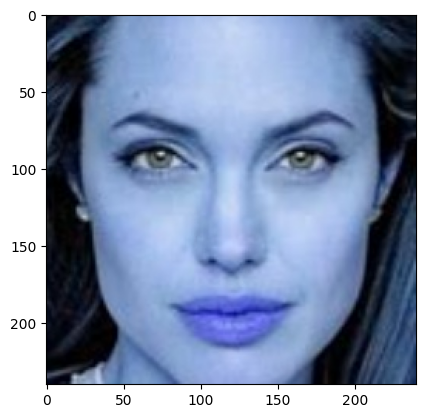

In [2]:
cropped_img = cv2.imread('../images/Angelina Jolie/100_31ff9373.jpg')
plt.imshow(cropped_img)

### Display Image

(240, 240)


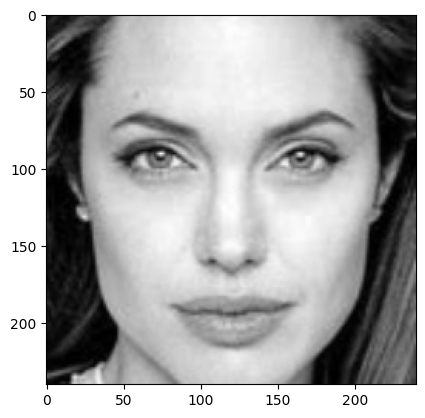

In [3]:
gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')

### Load Haarcascade Models for Face and Eye Detection

In [5]:
# Load Haarcascade model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
# Load Haarcascade model
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

### Apply Wavelet Transform

In [6]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

### Display Image

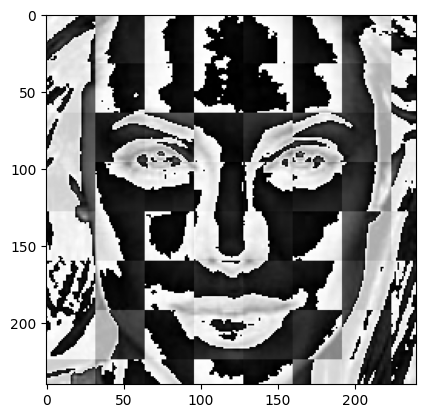

In [7]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

### Display Image

x,y,w,h : [[ 26  25 190 190]]


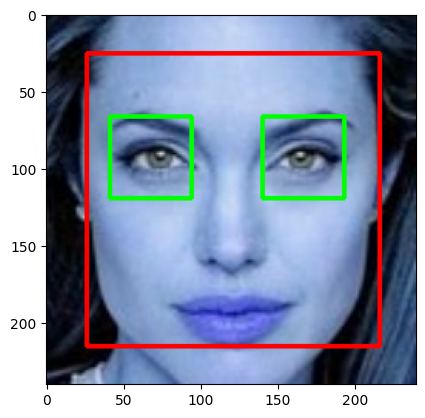

In [8]:
faces = face_cascade.detectMultiScale(cropped_img, 1.03, 3,minSize=(50,50))
print("x,y,w,h :",faces)
(x,y,w,h) = faces[0]
x,y,w,h
face_img = cv2.rectangle(cropped_img,(x,y),(x+w,y+h),(255,0,0),2)

cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(cropped_img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

### Display Image

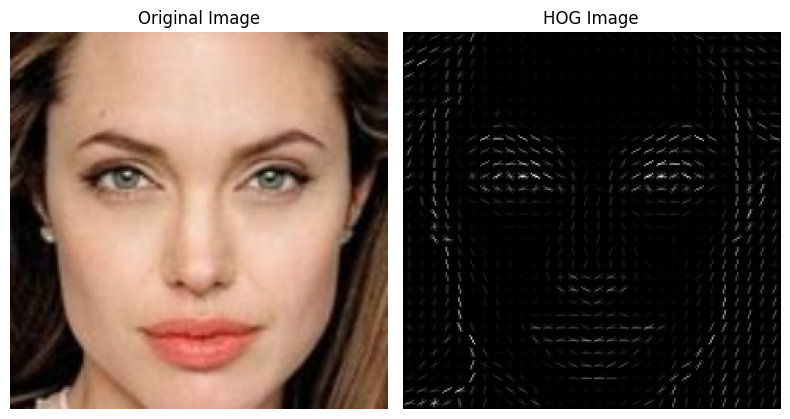

In [9]:
# Load image
image = cv2.imread('../images/Angelina Jolie/100_31ff9373.jpg')  # Replace with your image path
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute HOG features and visualization
features, hog_image = hog(gray_image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualize=True,
                          block_norm='L2-Hys')

# Display original and HOG image
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('HOG Image')
plt.imshow(hog_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [11]:
# Cropping the image else returning none
def get_cropped_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)  # Tweaked scaleFactor
    for (x, y, w, h) in faces:
        cropped_img = img[y:y+h, x:x+w]
        return cv2.resize(cropped_img, (250, 250))
    return None

### Display Image

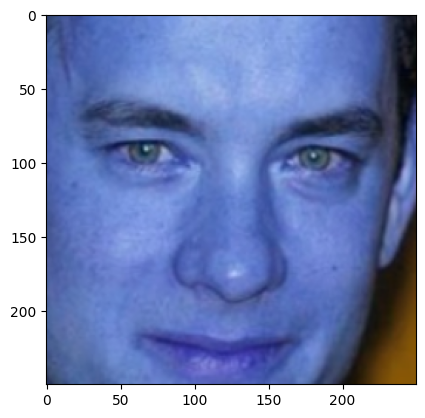

In [12]:
img = '../images/Tom Hanks/007_ba0aa044.jpg'
img = cv2.imread(img)
cropped_image = get_cropped_face(img)
plt.imshow(cropped_image)

In [24]:
celebrity_names = [
    "Angelina Jolie",
    "Brad Pitt",
    "Jennifer Lawrence",
    "Johnny Depp",
    "Megan Fox",
    "Robert Downey Jr",
    "Sandra Bullock",
    "Tom Cruise",
    "Tom Hanks",
    "Will Smith",
]

celebrity_file_names_dict = {}

root_dir = "../images"  # Base folder containing all celeb folders

for celeb in celebrity_names:
    img_dir = os.path.join(root_dir, celeb)  # Full path like images/Sandra Bullock
    file_list = []

    if not os.path.isdir(img_dir):
        print(f"Warning: {img_dir} does not exist or is not a directory.")
        continue

    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_list.append(entry.path)

    celebrity_file_names_dict[celeb] = file_list

# print(celebrity_file_names_dict)


In [14]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Jennifer Lawrence': 2,
 'Johnny Depp': 3,
 'Megan Fox': 4,
 'Robert Downey Jr': 5,
 'Sandra Bullock': 6,
 'Tom Cruise': 7,
 'Tom Hanks': 8,
 'Will Smith': 9}

### Extract HOG Features (Histogram of Oriented Gradients)

In [59]:
'''import cv2
import numpy as np
from skimage.feature import hog

# Your wavelet function (assuming it's already defined)
def w2d(img, mode='haar', level=1):
    import pywt
    import pywt.data
    imArray = img
    imArray = cv2.cvtColor(imArray,cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H

# HOG feature extractor
def extract_hog_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, _ = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )
    return features

# Final feature extractor
def extract_features(image_path):
    img = cv2.imread(image_path)

    # Resize image
    scalled_raw_img = cv2.resize(img, (64, 64))

    # Raw features (flattened)
    raw_features = scalled_raw_img.flatten()

    # Wavelet image
    img_har = w2d(img, 'db1', 5)
    scalled_img_har = cv2.resize(img_har, (64, 64))
    wavelet_features = scalled_img_har.flatten()

    # HOG features
    hog_features = extract_hog_features(scalled_raw_img)

    # Stack all features horizontally
    combined_features = np.hstack((raw_features, wavelet_features, hog_features))

    return combined_features
'''

"import cv2\nimport numpy as np\nfrom skimage.feature import hog\n\n# Your wavelet function (assuming it's already defined)\ndef w2d(img, mode='haar', level=1):\n    import pywt\n    import pywt.data\n    imArray = img\n    imArray = cv2.cvtColor(imArray,cv2.COLOR_BGR2GRAY)\n    imArray = np.float32(imArray)\n    imArray /= 255;\n    coeffs=pywt.wavedec2(imArray, mode, level=level)\n    coeffs_H=list(coeffs)  \n    coeffs_H[0] *= 0;  \n    imArray_H=pywt.waverec2(coeffs_H, mode);\n    imArray_H *= 255;\n    imArray_H = np.uint8(imArray_H)\n    return imArray_H\n\n# HOG feature extractor\ndef extract_hog_features(img):\n    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    features, _ = hog(\n        gray,\n        orientations=9,\n        pixels_per_cell=(8, 8),\n        cells_per_block=(2, 2),\n        visualize=True,\n        block_norm='L2-Hys'\n    )\n    return features\n\n# Final feature extractor\ndef extract_features(image_path):\n    img = cv2.imread(image_path)\n\n    # Resiz

### Extract HOG Features (Histogram of Oriented Gradients)
Using this one for better model performance

In [15]:
# --- Wavelet function ---
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray) / 255.0

    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0  # Set approximation coefficients to zero
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H = np.uint8(imArray_H * 255)
    return imArray_H

# --- HOG feature extractor ---
def extract_hog_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, _ = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )
    return features

# --- Final feature extractor (Wavelet + HOG only) ---
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Resize for consistency
    resized_img = cv2.resize(img, (64, 64))

    # Wavelet transform
    img_wavelet = w2d(img, 'db1', 5)
    resized_wavelet = cv2.resize(img_wavelet, (64, 64))
    wavelet_features = resized_wavelet.flatten()

    # HOG features from resized original image
    hog_features = extract_hog_features(resized_img)

    # Combine Wavelet + HOG
    combined_features = np.hstack((wavelet_features, hog_features))

    return combined_features

In [16]:
features = extract_features('../images/Tom Hanks/006_a28f75e7.jpg')
features
print("Feature vector length:", len(features))

Feature vector length: 5860


In [20]:
# celebrity_file_names_dict

In [21]:
X = []  # Feature list
y = []  # Labels

for celeb in celebrity_file_names_dict:
    for img_path in celebrity_file_names_dict[celeb]:
        feature_vector = extract_features(img_path)
        X.append(feature_vector)
        y.append(celeb)

In [22]:
# y

In [23]:
y = [class_dict[name] for name in y]

In [66]:
df = pd.DataFrame(X)
df['target'] = y
df.shape

(1074, 5861)

In [67]:
df

,0,1,2,3,4,5,6,7,8,9,...,5851,5852,5853,5854,5855,5856,5857,5858,5859,target
0,125.0,123.0,128.0,120.0,109.0,82.0,166.0,161.0,167.0,192.0,...,0.254918,0.323605,0.211257,0.175813,0.128751,0.035047,0.035716,0.000000,0.035318,0
1,113.0,55.0,39.0,18.0,149.0,246.0,245.0,243.0,223.0,187.0,...,0.145716,0.178359,0.056384,0.026424,0.070687,0.123248,0.062675,0.067415,0.016798,0
2,226.0,224.0,224.0,230.0,230.0,249.0,239.0,10.0,70.0,193.0,...,0.302701,0.220287,0.092888,0.081615,0.109568,0.012160,0.006507,0.024314,0.002058,0
3,96.0,96.0,255.0,254.0,254.0,4.0,4.0,255.0,70.0,198.0,...,0.453726,0.259827,0.028237,0.000000,0.039947,0.000000,0.018847,0.009495,0.051600,0
4,15.0,221.0,247.0,223.0,59.0,48.0,66.0,102.0,204.0,165.0,...,0.128617,0.021093,0.024796,0.006242,0.034047,0.004779,0.009120,0.072416,0.042194,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,43.0,43.0,44.0,44.0,44.0,45.0,42.0,45.0,49.0,27.0,...,0.134744,0.041641,0.049692,0.000000,0.020549,0.006498,0.011624,0.009190,0.006498,9
1070,171.0,172.0,172.0,174.0,174.0,176.0,179.0,185.0,189.0,195.0,...,0.327607,0.327607,0.000000,0.000000,0.115931,0.027686,0.062939,0.327607,0.327607,9
1071,33.0,34.0,34.0,34.0,35.0,35.0,36.0,36.0,37.0,37.0,...,0.236403,0.012538,0.002643,0.015412,0.041118,0.090858,0.148594,0.074776,0.046016,9
1072,224.0,224.0,224.0,225.0,225.0,225.0,225.0,225.0,225.0,225.0,...,0.073783,0.066248,0.032825,0.004837,0.160710,0.028448,0.049234,0.006839,0.124471,9


In [68]:
X = df.drop('target', axis=1)
y = df['target']
X.shape, y.shape

((1074, 5860), (1074,))

In [69]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1069    9
1070    9
1071    9
1072    9
1073    9
Name: target, Length: 1074, dtype: int64

### 🤖 Train the Model

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

1. ('svc', SVC(kernel = 'linear', C = 1)) for wav+row+hog / 32x32  = .70
2. ('svc', SVC(kernel = 'rbf', C = 10) for wav+hog / 32x32 = 0.68
3. ('lr', LogisticRegression(C = 0.5) for wav+row+hog / 32x32 = 0.72
4. ('lr', LogisticRegression(C = 10) for wav+hog / 32x32  = 0.68
5. ('lr', LogisticRegression(C = 1)) for wav+hog / 64x64 = 0.79
6. ('svc', SVC(kernel = 'linear', C = 1) for wav+hog / 64x64 = 0.776

In [71]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 1))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.813953488372093

In [72]:
pipe2 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(C = 1))])
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.8093023255813954

In [73]:
import pickle
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 1))])
pipe.fit(X, y)

with open('../celebrity_face_svm_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [74]:
pipe2 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(C = 1))])
pipe2.fit(X, y)

with open('../celebrity_face_lr_model.pkl', 'wb') as f:
    pickle.dump(pipe2, f)